## Traffic Predictor

Firstly import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import requests
import matplotlib
import time
import os
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import requests
from staticmap import StaticMap, Line, CircleMarker
from matplotlib import pyplot as plt
hours = list(range(24))




Data collection and preprocessing

In [ ]:
#Phase 1: Setup & Data Collection
#https://developer.tomtom.com/user/me/apps?type=free

API_KEY = "YOURAPI"

# Coordinates in lat,long format
destination = "25.3061594,55.4538881"      # Muwaileh Park
origin = "25.2302654,55.3886272" # Centerpoint Metro

url = f"https://api.tomtom.com/routing/1/calculateRoute/{origin}:{destination}/json"

params = {
    "key": API_KEY,
    "traffic": "true",                     
    "travelMode": "car",
    "routeType": "fastest",
    "computeBestOrder": "false",
    "departAt":"now"
}

response = requests.get(url, params=params)
data = response.json()

if 'routes' in data:
    duration_sec = data['routes'][0]['summary']['travelTimeInSeconds']
    duration_min = duration_sec / 60
    print(f"Estimated travel time (with traffic): {duration_min:.1f} minutes")
else:
    print("Error:", data)

#Use below code for collecting data only
"""
#Phase 2: Data Preprocessing
while True:
    response = requests.get(url, params=params)
    data = response.json()

    if 'routes' in data:
        duration_sec = data['routes'][0]['summary']['travelTimeInSeconds']
        duration_min = duration_sec / 60
    else:
        print("Error fetching data from TomTom API:", data)
        time.sleep(600)
        continue
    from openpyxl import load_workbook 
    filename = "traffic_data _return.xlsx"

    travel_time_min = duration_min
    now = datetime.now()
    hour = now.hour
    day = now.strftime('%A')
    timestamp = now.strftime('%Y-%m-%d %H:%M:%S')


    new_data = pd.DataFrame([{
        'timestamp': timestamp,
        'hour': hour,
        'day': day,
        'travel_time_min': travel_time_min
    }])

    if os.path.exists(filename):
        with pd.ExcelWriter(filename, mode='a', engine='openpyxl', if_sheet_exists='overlay') as writer:
            existing_data = pd.read_excel(filename)
            startrow = existing_data.shape[0] + 1
            new_data.to_excel(writer, index=False, header=False, startrow=startrow)
    else:
        new_data.to_excel(filename, index=False)

    time.sleep(600) 
"""

Estimated travel time (with traffic): 10.9 minutes


'\n#Phase 2: Data Preprocessing\nwhile True:\n    response = requests.get(url, params=params)\n    data = response.json()\n\n    if \'routes\' in data:\n        duration_sec = data[\'routes\'][0][\'summary\'][\'travelTimeInSeconds\']\n        duration_min = duration_sec / 60\n    else:\n        print("Error fetching data from TomTom API:", data)\n        time.sleep(600)\n        continue\n    from openpyxl import load_workbook \n    filename = "traffic_data _return.xlsx"\n\n    travel_time_min = duration_min\n    now = datetime.now()\n    hour = now.hour\n    day = now.strftime(\'%A\')\n    timestamp = now.strftime(\'%Y-%m-%d %H:%M:%S\')\n\n\n    new_data = pd.DataFrame([{\n        \'timestamp\': timestamp,\n        \'hour\': hour,\n        \'day\': day,\n        \'travel_time_min\': travel_time_min\n    }])\n\n    if os.path.exists(filename):\n        with pd.ExcelWriter(filename, mode=\'a\', engine=\'openpyxl\', if_sheet_exists=\'overlay\') as writer:\n            existing_data = pd.

Directories

In [15]:
togotdata = pd.read_excel("traffic_data_to_go.xlsx")
togotdata.drop(columns=['timestamp'], inplace=True)
returndata = pd.read_excel("traffic_data _return.xlsx")
returndata.drop(columns=['timestamp'], inplace=True)


KMeans Clustering

In [16]:

# One-Hot Encoding
togotdata_encoded = pd.get_dummies(togotdata, columns=['day'])
returndata_encoded = pd.get_dummies(returndata, columns=['day'])

# KMeans
kmeans = KMeans(n_clusters=2)
kmeans1 = KMeans(n_clusters=2)

ktogo = kmeans.fit(togotdata_encoded.drop(columns=['travel_time_min']))
kreturn = kmeans1.fit(returndata_encoded.drop(columns=['travel_time_min']))

# Labelling
labels = kmeans.labels_
labels1 = kmeans1.labels_
togotdata_encoded['cluster'] = labels
returndata_encoded['cluster'] = labels1

# Cluster Centers
centers = kmeans.cluster_centers_
centers1 = kmeans1.cluster_centers_


Prediction Model (Random Forest)

In [31]:
'''
#   Legacy function
def predictdata(a,b):
    togotdata_encoded['cluster'] = labels
    returndata_encoded['cluster'] = labels1

    X = togotdata_encoded.drop(columns=['travel_time_min'])  
    y = togotdata_encoded['travel_time_min']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    mae = mean_absolute_error(y_test, predicted)
    best_hour = togotdata['hour'][np.argmin(predicted)]

    input_row = pd.DataFrame(columns=X.columns)
    input_row.loc[0] = 0

    day_col = f'day_{a.capitalize()}'
    if day_col in input_row.columns:
        input_row.at[0, day_col] = 1

    for col in input_row.columns:
        if col != day_col:
            input_row.at[0, col] = X[col].median()

    day_prediction = model.predict(input_row)[0]
    print(f"Predicted travel time on {a} is {day_prediction:.2f} minutes")
'''

def predictdatawdate(a, b):
    global direction_flag

    if direction_flag == "go":
        df_encoded = togotdata_encoded
        labels_local = labels
    else:
        df_encoded = returndata_encoded
        labels_local = labels1

    df_encoded['cluster'] = labels_local

    X = df_encoded.drop(columns=['travel_time_min'])
    y = df_encoded['travel_time_min']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    mae = mean_absolute_error(y_test, predicted)

    best_time = None
    best_prediction = float('inf')

    for hr in b:
        input_row = pd.DataFrame(columns=X.columns)
        input_row.loc[0] = 0

        if 'hour' in input_row.columns:
            input_row.at[0, 'hour'] = hr

        day_col = f'day_{a.capitalize()}'
        if day_col in input_row.columns:
            input_row.at[0, day_col] = 1
        else:
            print(f"Invalid day: {a}")
            return

        for col in input_row.columns:
            if col not in ['hour', day_col]:
                input_row.at[0, col] = X[col].median()

        for col in input_row.columns:
            if isinstance(input_row.at[0, col], str):
                print(f"⚠️ Column '{col}' has invalid string '{input_row.at[0, col]}'. Replacing with median.")
                input_row.at[0, col] = X[col].median()

        pred = model.predict(input_row)[0]

        if pred < best_prediction:
            best_prediction = pred
            best_time = hr

    global feature_columns
    feature_columns = X.columns.tolist()

    print(f"Best hour to leave on {a.capitalize()} is {best_time}:00 with predicted travel time {best_prediction:.2f} minutes.")
    print(f"Model scores")
    print("R score:", model.score(X_test, y_test))
    print("MAE: ", mae)



Other functions

In [ ]:
try:
    feature_columns
except NameError:
    try:
        feature_columns = X.columns.tolist()
    except NameError:
        feature_columns = []
        print("Cannot set feature_columns: X is not defined. Train the model first.")


def userinput():
    global X, feature_columns, model, current_dataset

    e = input("Would you like to see the traffic now or prediction?: \nEnter Now for realtime traffic: ").capitalize()
    r = e.capitalize()
    if r not in ["Now", "Prediction", "Predict"]:
        print("Invalid input")
        return

    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    if r == "Now":
        currentraffic()
        return
    else:
        x = input("Enter the day you want to see the traffic: ").capitalize()
        y = x
        if y not in days:
            print("You have not entered the data properly. Please try again.")
            return

        j = input("Do you want to know what time you'll reach if you leave at a certain time? ").capitalize()
        if j == "Yes":
            timegiven(y)
        else:
            for day in days:
                current_dataset[f'day_{day}'] = 0
            current_dataset[f'day_{y}'] = 1

            print(f"Day set to {y} in the dataset.")
            g = input("What time of day? (morning / afternoon / evening / night): ").capitalize()

            time_map = {
                "Morning": list(range(6, 12)),
                "Afternoon": list(range(12, 17)),
                "Evening": list(range(17, 21)),
                "Night": list(range(21, 24)) + list(range(0, 6))
            }

            if g in time_map:
                predictdatawdate(y, time_map[g])
            else:
                print("Invalid time of day entered.")
                return

def currentraffic():
    API_KEY = "YOURAPI"
    destination = "25.3061594,55.4538881"  # Muwaileh Park
    origin = "25.2302654,55.3886272"       # Centerpoint Metro

    url = f"https://api.tomtom.com/routing/1/calculateRoute/{origin}:{destination}/json"
    params = {
        "key": API_KEY,
        "traffic": "true",
        "travelMode": "car",
        "routeType": "fastest",
        "computeBestOrder": "false",
        "departAt": "now"
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'routes' in data:
        duration_sec = data['routes'][0]['summary']['travelTimeInSeconds']
        duration_min = duration_sec / 60
        print(f"Estimated travel time (with traffic): {duration_min:.1f} minutes")
    else:
        print("Error:", data)

def timegiven(day):
    global model, feature_columns, X

    if 'current_dataset' not in globals():
        print("current_dataset not set. Please try again.")
        return

    if not feature_columns or model is None:
        print("Model not trained yet.")
        return

    try:
        hour = int(input("Enter the hour (0-23): "))
        if not (0 <= hour <= 23):
            print("Hour must be between 0 and 23.")
            return
    except ValueError:
        print("Hour must be an integer.")
        return

    input_row = pd.DataFrame(columns=feature_columns)
    input_row.loc[0] = 0

    if 'hour' in input_row.columns:
        input_row.at[0, 'hour'] = hour

    day_col = f'day_{day}'
    if day_col in input_row.columns:
        input_row.at[0, day_col] = 1
    else:
        print(f"Column {day_col} not in data.")
        return

    for col in input_row.columns:
        if col not in ['hour', day_col]:
            try:
                input_row.at[0, col] = X[col].median()
            except:
                input_row.at[0, col] = 0

    try:
        prediction = model.predict(input_row)[0]
        print(f"✅ Predicted travel time on {day} at {hour}:00 is {prediction:.2f} minutes.")
    except Exception as e:
        print(f"Prediction failed: {e} — Please try again")


def direction_input():
    global active_df, active_labels, model, X, y, feature_columns, current_dataset, direction_flag

    while True:
        direction = input("Do you want to go to Centerpoint or come back from Centerpoint? (Enter 'go' or 'return'): ").strip().lower()
        if direction in ['go', 'return']:
            break
        else:
            print("Invalid input. Please type 'go' or 'return'.")

    if direction == 'go':
        print("You chose to go to Centerpoint.")
        chosen_df = togotdata_encoded
        direction_flag = "go"
        current_dataset = togotdata_encoded
        chosen_labels = labels
        destination = "25.3061594,55.4538881"  # Muwaileh Park
        origin = "25.2302654,55.3886272"       # Centerpoint Metro
    else:
        print("You chose to return from Centerpoint.")
        direction_flag = "return"
        current_dataset = returndata_encoded
        chosen_df = returndata_encoded
        chosen_labels = labels1
        origin = "25.3061594,55.4538881"       # Muwaileh Park
        destination = "25.2302654,55.3886272"  # Centerpoint Metro

    try:
        points = data["routes"][0]["legs"][0]["points"]
        route_coords = [(p["longitude"], p["latitude"]) for p in points]

        m = StaticMap(800, 600)
        m.add_marker(CircleMarker(route_coords[0], 'green', 12))
        m.add_marker(CircleMarker(route_coords[-1], 'red', 12))
        m.add_line(Line(route_coords, 'blue', 4))
        image = m.render()

        filename = f'route_map_{direction}.png'
        image.save(filename)
        print(f"Saved route map as '{filename}'")

        plt.imshow(plt.imread(filename))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to render map: {e}")

    active_df = chosen_df
    active_labels = chosen_labels

    active_df['cluster'] = active_labels

    X = active_df.drop(columns=['travel_time_min'])
    y = active_df['travel_time_min']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    feature_columns = X.columns.tolist()

    print("Model trained on selected route data.")

    userinput()


Insights & Output

You chose to go to Centerpoint.
Saved route map as 'route_map_go.png'


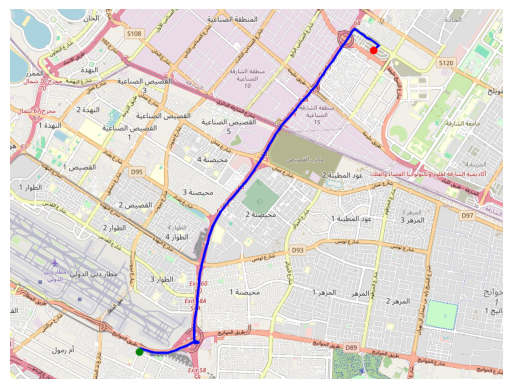

Model trained on selected route data.
Day set to Saturday in the dataset.
Best hour to leave on Saturday is 20:00 with predicted travel time 19.93 minutes.
Model scores
R score: 0.49771574439815625
MAE:  3.8257305747973835


In [42]:
direction_input()